# Pharmacy SVD Matrix Factorization

In [1]:
import numpy as np
import pandas as pd

# Local libraries should automatically reload
%load_ext autoreload
%autoreload 1

# assign GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Generate input Matrix

In [2]:
%aimport gpudb_df
_cnxn = gpudb_df.get_odbc()

_sql = """
create or replace table {}.PHARM_MATRIX as (
    select 
        rtf.PATIENT_ID,
        p.GENDER,
        d.THERAPEUTIC_IDENTIFIER as TID,
        count(1) as RX_COUNT
    from PHARM_TXN_LOG as rtf
    join PHARM_DRUG as d
        ON d.SRC_NHIN_STORE_ID = rtf.SRC_NHIN_STORE_ID
        AND rtf.DISPENSED_DRUG_NDC = d.NDC
    join PHARM_PATIENT p
        on p.SRC_NHIN_STORE_ID = rtf.SRC_NHIN_STORE_ID
        and p.ID = rtf.PATIENT_ID
    where rtf.SRC_NHIN_STORE_ID = 900002841
    group by 1,2,3
)
""".format(gpudb_df.SCHEMA)

_cnxn.execute(_sql)
_cnxn.close()

print('Created PHARM_MATRIX')

Connected to GPUdb ODBC Server (6.2.0.9.20180622232941)
Created PHARM_MATRIX


### Load input matrix from PHARMACY_MATRIX

In [3]:
%aimport gpudb_df

# load input table
_table_df = gpudb_df.load_df('PHARM_MATRIX')
_table_df.head()

Getting records from <PHARM_MATRIX>...........
Records Retrieved: (106457, 4)


,GENDER,PATIENT_ID,RX_COUNT,TID
0,M,3,1,2737
1,M,3,1,3925
2,M,3,1,583
3,M,3,1,649
4,F,4,1,11


### Construct sparse matrix

In [4]:
# Construct sparse matrix
_matrix_df = pd.crosstab(
    _table_df.PATIENT_ID, 
    _table_df.TID, 
    _table_df.RX_COUNT, 
    aggfunc=np.sum, 
    normalize=False).fillna(0)
_matrix_df.head()

TID,1002,1013,104,105,106,108,11,1133,1139,1149,...,947,95,954,960,963,977,981,986,990,994
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Generate SVD Results

In this example we factor a sparse matrix $\mathbf{M}$ of dimensions $patients \times drugs$ into 3 separate components of the form $\mathbf{M} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^*$.

* $\mathbf{M}$ is the sparse matrix containg drugs purchased.
* $\mathbf{U}$ has rows of patients and columns of **right singular vectors**.
* $\mathbf{V}$ has rows of drugs and columns of **left singular vectors**.
* $\boldsymbol{\Sigma}$ is a rectangular diagonal matrix containing the **singular values** $\sigma_i$.

We can truncate trailing singular vectors to get a reduced rank approximation 

$\tilde{\mathbf{M}} = \mathbf{U} \tilde{\boldsymbol{\Sigma}} \mathbf{V}^T$ 

where $\tilde{\boldsymbol{\Sigma}}$ has truncated diagonal values and $\tilde{\mathbf{M}}$ is an approximation of the original sparse matrix.

We can multiply the singular values from $ \boldsymbol{\Sigma}$ into $\mathbf{U}$ and $\mathbf{V}$. This gives matrices with magnitueds that can be used for clustering.

$
\mathbf{M} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T
= (\sqrt{\boldsymbol{\Sigma}} \mathbf{U}) ( \sqrt{\boldsymbol{\Sigma}} \mathbf{V}^T )
$

In [5]:
# convert to numpy
_matrix_np = _matrix_df.values.astype(np.float64)

import torch as th
print('Calculating SVD...')
#_matrix_cuda = th.tensor(_matrix_np).cuda()
_matrix_cuda = th.tensor(_matrix_np)
_svd_u, _svd_s, _svd_v = th.svd(_matrix_cuda)

print('SVD dimensions: U={} sig={} V={}'
    .format([*_svd_u.shape], [*_svd_s.shape], [*_svd_v.shape]))

# truncate to create the approximation
TRUNCATE_VECTORS = 10
_dim = min(TRUNCATE_VECTORS, _svd_u.shape[1])
_svd_u_approx = _svd_u[: , :_dim]
_svd_s_approx = _svd_s[:_dim]
_svd_v_approx = _svd_v[: , :_dim]

print('SVD approximated: U={} sig={} V={}'
    .format([*_svd_u_approx.shape], [*_svd_s_approx.shape], [*_svd_v_approx.shape]))

# multiuply U and V by sqrt(S)
_svd_s_eigen = th.sqrt(_svd_s_approx).diag()
_svd_u_eigen = _svd_u_approx.matmul(_svd_s_eigen)
_svd_v_eigen = _svd_v_approx.matmul(_svd_s_eigen)

print('SVD eigen: U={} V={}'
    .format([*_svd_u_eigen.shape], [*_svd_v_eigen.shape]))

Calculating SVD...
SVD dimensions: U=[19092, 493] sig=[493] V=[493, 493]
SVD approximated: U=[19092, 10] sig=[10] V=[493, 10]
SVD eigen: U=[19092, 10] V=[493, 10]


### Save results to Kinetica

Save U and V to `PATIENT_U_VEC` and `DRUG_V_VEC` tables.

In [6]:
%aimport gpudb_df

# create column names for the vector
_col_names = ['v' + str(i) for i in range(_svd_u_eigen.shape[1])]

_patient_sv = pd.DataFrame(_svd_u_eigen.cpu().numpy(), 
                        columns=_col_names,
                        index=_matrix_df.index)
gpudb_df.save_df(_patient_sv, 'PATIENT_U_VEC')
_patient_sv.head()

Dropping table: <PATIENT_U_VEC>
Creating table: <PATIENT_U_VEC>
Column 0: <PATIENT_ID> (long)
Column 1: <v0> (double)
Column 2: <v1> (double)
Column 3: <v2> (double)
Column 4: <v3> (double)
Column 5: <v4> (double)
Column 6: <v5> (double)
Column 7: <v6> (double)
Column 8: <v7> (double)
Column 9: <v8> (double)
Column 10: <v9> (double)
Inserted rows into <PHARMACY.PATIENT_U_VEC>: 19092


,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9
PATIENT_ID,,,,,,,,,,
3,-0.026869,0.003544,0.067632,0.007149,0.019579,-0.012598,0.039725,0.012359,-0.002720,0.005420
4,-1.025537,-0.915222,-0.135088,0.506937,-0.046075,-0.790646,-0.736051,-0.174529,-0.203942,-0.047053
6,-0.835222,-0.685774,-0.319621,-0.053120,0.135096,0.106425,0.025238,-0.039275,-0.001030,-0.026680
7,-0.465780,-0.495243,-0.087060,0.222816,0.009257,-0.530207,-0.575800,-0.017807,-0.002585,0.176052
9,-0.065967,0.046649,0.009301,0.070871,-0.131696,-0.014793,-0.015506,-0.036466,0.100262,-0.003387


In [7]:
_drug_sv = pd.DataFrame(_svd_v_eigen.cpu().numpy(),
                        columns=_col_names,
                        index=_matrix_df.columns.astype(int, copy=True))
gpudb_df.save_df(_drug_sv, 'DRUG_V_VEC')
_drug_sv.head()

Dropping table: <DRUG_V_VEC>
Creating table: <DRUG_V_VEC>
Column 0: <TID> (long)
Column 1: <v0> (double)
Column 2: <v1> (double)
Column 3: <v2> (double)
Column 4: <v3> (double)
Column 5: <v4> (double)
Column 6: <v5> (double)
Column 7: <v6> (double)
Column 8: <v7> (double)
Column 9: <v8> (double)
Column 10: <v9> (double)
Inserted rows into <PHARMACY.DRUG_V_VEC>: 493


,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9
TID,,,,,,,,,,
1002,-0.000073,0.000065,0.000042,0.000162,-0.000097,0.000235,0.000028,-0.000095,0.000270,-0.000164
1013,-0.000082,-0.000091,0.000005,0.000045,0.000072,-0.000102,0.000255,0.000048,0.000003,-0.000002
104,-0.029558,0.019072,-0.005004,-0.014532,0.019556,0.016535,-0.007420,0.022379,-0.007007,-0.029908
105,-0.027096,0.021333,0.013344,0.024419,-0.051139,-0.025255,0.010653,-0.026288,-0.011587,-0.062321
106,-0.099617,0.031942,-0.049758,-0.016589,-0.071673,-0.009588,-0.015417,0.048431,0.011317,0.003594


# Result Analisys

### Plot singular values

The $\Sigma$ matrix contains the singular values that give the magnitudes of the singular vectors. We can calculate how much we lose through truncation.

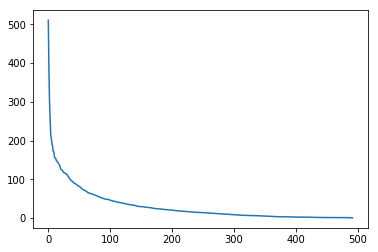

In [9]:
from matplotlib import pyplot as plt

_svd_s_np = _svd_s.cpu().numpy()
plt.plot(np.arange(493), _svd_s_np)

### Calculate Error

$
1 - \frac{\sum_i^T \sigma}{\sum_i \sigma}
$

In [10]:
TRUNCATE_COUNT = 10
_svd_s_sum = th.sum(_svd_s).item()
_svd_s_sum_approx = th.sum(_svd_s[:TRUNCATE_COUNT]).item()
_error = 1 - (_svd_s_sum_approx/_svd_s_sum)

print('Error with {} vectors: {:.2%}'.format(TRUNCATE_COUNT, _error))

Error with 10 vectors: 83.01%


### Calculate approximated matrix

In [11]:
print('SVD approx: U={} s={} V={}'
    .format([*_svd_u_approx.shape], [*_svd_s_approx.shape], [*_svd_v_approx.shape]))

# calculate reduced rank matrix
_svd_s_diag = th.diag(_svd_s_approx)
_svd_v_t = _svd_v_approx.t()
_matrix_approx_cuda = _svd_u_approx.matmul(_svd_s_diag).matmul(_svd_v_t)

# copy result back from vRAM to RAM
_matrix_approx_np = _matrix_approx_cuda.cpu().numpy()

SVD approx: U=[19092, 10] s=[10] V=[493, 10]


### Calculate RMSD of approximated matrices
$
\operatorname{RMSD}= \sqrt{\frac{\sum_{t=1}^T (x_{1,t} - x_{2,t})^2}{T}}
$

In [12]:
import math

def rmsd(_x1, _x2):
    _sqr = (_x1 - _x2) ** 2
    _sum = th.sum(_sqr).item()
    _num = float(th.numel(_x1))
    _rmsd = math.sqrt( _sum/_num )
    return _rmsd

_rmsd = rmsd(_matrix_approx_cuda, _matrix_cuda)
print('RMSD = {}'.format(_rmsd))

RMSD = 0.2998927752739566


### Calculate RMSD of eigen matrices
Should be the same as above

In [13]:
print('SVD eigen: U={} V={}'
    .format([*_svd_u_eigen.shape], [*_svd_v_eigen.shape]))

_matrix_approx_cuda = _svd_u_eigen.matmul(_svd_v_eigen.t())
_matrix_approx_np = _matrix_approx_cuda.cpu().numpy()
_rmsd = rmsd(_matrix_approx_cuda, _matrix_cuda)
print('RMSD = {}'.format(_rmsd))

SVD eigen: U=[19092, 10] V=[493, 10]
RMSD = 0.2998927752739565


### Calculate RMSD of each patient

In [14]:
print('Input matrices: orig={} approx={}'
    .format([*_matrix_cuda.shape], [*_matrix_approx_cuda.shape]))

_diff = _matrix_cuda - _matrix_approx_cuda
_rmsd = _diff.pow(2).mean(dim=1).sqrt()
_rmsd_df = pd.DataFrame(_rmsd.cpu().numpy(), 
                        columns=['RMSD'], 
                        index=_matrix_df.index)

_rmsd_df.sort_values('PATIENT_ID', ascending=True).head(10)

Input matrices: orig=[19092, 493] approx=[19092, 493]


,RMSD
PATIENT_ID,
3,0.108397
4,1.486248
6,0.785072
7,0.259111
9,0.215524
10,0.246505
11,0.045006
12,0.283255
13,0.137662


### Compare original with reduced rank matrix

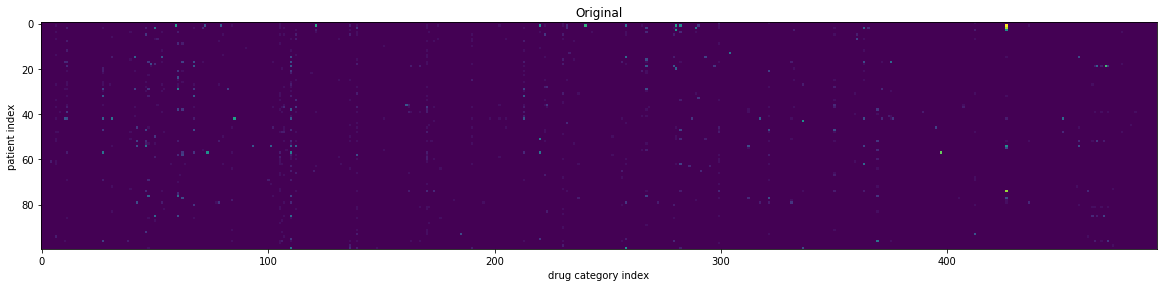

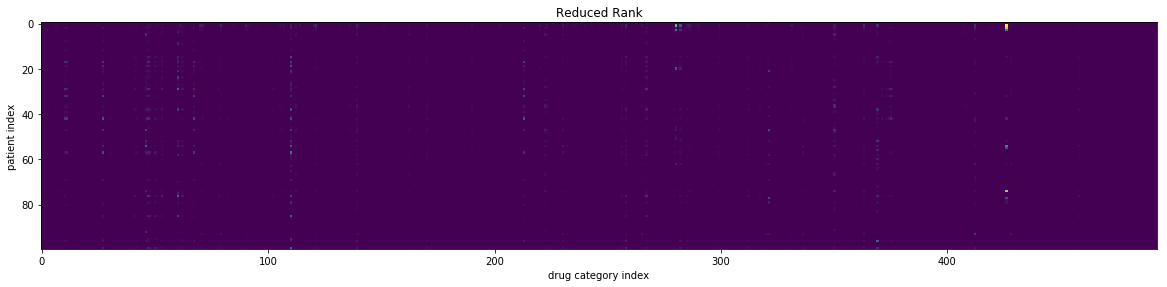

In [16]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,150))
plt.imshow(_matrix_np[:100,:])
plt.xlabel('drug category index')
plt.ylabel('patient index')
plt.title('Original')
plt.show()

# remove values < 0
_matrix_approx_fix = np.copy(_matrix_approx_np)
_matrix_approx_fix[_matrix_approx_fix < 0] = 0

plt.figure(figsize=(20,150))
plt.imshow(_matrix_approx_fix[:100,:1000])
plt.xlabel('drug category index')
plt.ylabel('patient index')
plt.title('Reduced Rank')
plt.show()

### Orthogonality

Dot product of any 2 columns is zero because the columns are orthogonal:

$\langle\mathbf{U_{j}},\mathbf{U_{k}}\rangle = 0$

Magnitude of any column is 1 because each column is a unit vector:

$\Vert \mathbf{U_{j}} \Vert^2$ = 1

In [ ]:
u0 = _svd_u[:, 0]
u1 = _svd_u[:, 1]

dot = th.dot(u0,u0)
print('Dot product of u0,u0 is: {:f}'.format(dot.item()))

dot = th.dot(u0,u1)
print('Dot product of u0,u1 is: {:f}'.format(dot.item()))